In [1]:
import json
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, cross_validate
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [2]:
with open('Coursework_data', 'r', encoding='utf-8') as f:
    data = json.loads(f.read())   
data = pd.DataFrame(data)    
data

,01,0kpd2_general,10,URL,deadline_pay,diff_cr_and_cont,duration_2,gosob_z,h_0,h_1,...,unit_Литр;^кубический дециметр,unit_Штука,w_day_123,w_day_4,w_day_5,weekend,Закупка до 300 000 руб. (п.4 ст.93 Закона №44-ФЗ),Закупка до 600 000 руб. (п.4 ч.1 ст.93 Закона №44-ФЗ),Закупка до 600 000 руб. (п.5 ч.1 ст.93 Закона №44-ФЗ),Закупка_general
0,0.0,0.0,2.0,1000343,30,2,1.0,1,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,1000429,30,3,1.0,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,3.0,1000450,15,3,1.0,0,0.0,0.0,...,0.0,50.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,1.0,1000520,0,1,0.0,0,0.0,0.0,...,0.0,130.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,1000653,0,1,1.0,0,0.0,0.0,...,0.0,100.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9967,3.0,0.0,0.0,999573/,0,1,1.0,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9968,1.0,0.0,5.0,999726/,0,3,1.0,0,0.0,0.0,...,0.0,6.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9969,0.0,0.0,1.0,999819/,0,1,1.0,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9970,0.0,0.0,3.0,999837/,0,3,1.0,0,0.0,0.0,...,0.0,2880.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [3]:
data['status'].value_counts()

0    8332
1    1634
Name: status, dtype: int64

Неудачных закупок 8332, это 83,6% - бейзлайн для доли правильных ответов!

Для заказчика наиболее важна метрика точность для 1-го класса, так что будем ориентироваться на нее при выборе аглгоритма в первую очередь.

In [4]:
y = data['status']
X = data.drop(columns=['URL', 'status'])

In [5]:
train_data, val_data, train_labels, val_labels = train_test_split(X, y, stratify=y, test_size=0.3)

# test_data, val_data, test_labels, val_labels = train_test_split(val_data, val_labels, test_size=0.5, stratify=test_labels)

In [6]:
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
val_data = scaler.transform(val_data)
# test_data = scaler.transform(test_data)

In [7]:
train_data.shape

(6976, 60)

In [8]:
val_data.shape

(2990, 60)

In [9]:
train_labels.value_counts()
# val_labels.value_counts()

0    5832
1    1144
Name: status, dtype: int64

### Функция для отрисовки красивой confusion_matrix

In [49]:
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [50]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Логистическая регрессия

In [15]:
model = LogisticRegression(solver='newton-cg', class_weight='balanced', n_jobs=-1)
log_reg_scoring = cross_validate(model, train_data, train_labels, scoring = ['accuracy', 'precision','recall'], cv = 5)

print('log_reg_test_accuracy: ', log_reg_scoring['test_accuracy'].mean())
print('log_reg_test_precision: ', log_reg_scoring['test_precision'].mean())
print('log_reg_test_recall: ', log_reg_scoring['test_recall'].mean())

log_reg_test_accuracy:  0.7518619506834685
log_reg_test_precision:  0.37485533556196593
log_reg_test_recall:  0.7701064889297479


In [16]:
model_LR = LogisticRegression(solver='newton-cg', class_weight='balanced', n_jobs=-1)
model_LR.fit(train_data, train_labels)
predicted_LR = model_LR.predict(val_data)
print(classification_report(val_labels, predicted_LR))

              precision    recall  f1-score   support

           0       0.94      0.74      0.83      2500
           1       0.36      0.76      0.49       490

    accuracy                           0.74      2990
   macro avg       0.65      0.75      0.66      2990
weighted avg       0.85      0.74      0.77      2990



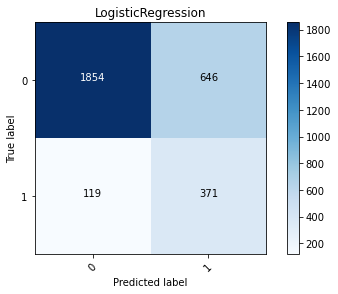

In [17]:
plot_confusion_matrix(confusion_matrix(val_labels, predicted_LR), classes=['0','1'],
                        title='LogisticRegression')

## K-ближайших соседей

In [18]:
model = KNeighborsClassifier(weights='distance')
KN_scoring = cross_validate(model, train_data, train_labels, scoring = ['accuracy', 'precision','recall'], cv = 5)

print('KN_test_accuracy: ', KN_scoring['test_accuracy'].mean())
print('KN_test_precision: ', KN_scoring['test_precision'].mean())
print('KN_test_recall: ', KN_scoring['test_recall'].mean())

KN_test_accuracy:  0.8562197163426483
KN_test_precision:  0.5875697907878397
KN_test_recall:  0.4134796598483107


In [19]:
model_KN = KNeighborsClassifier(weights='distance')
model_KN.fit(train_data, train_labels)
predicted_KN = model_KN.predict(val_data)
print(classification_report(val_labels, predicted_KN))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2500
           1       0.60      0.42      0.50       490

    accuracy                           0.86      2990
   macro avg       0.75      0.69      0.71      2990
weighted avg       0.85      0.86      0.85      2990



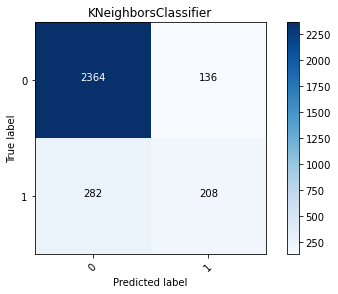

In [20]:
plot_confusion_matrix(confusion_matrix(val_labels, predicted_KN), classes=['0','1'],
                     title= 'KNeighborsClassifier')

In [21]:
# для увеличения точности повысим порог вероятности для отнесения объекта к классу 1
threshold = 0.6

predicted_proba = model_KN.predict_proba(val_data)
predicted_KN_6 = (predicted_proba[:,1] >= threshold).astype('int')

print(classification_report(val_labels, predicted_KN_6))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2500
           1       0.65      0.36      0.46       490

    accuracy                           0.86      2990
   macro avg       0.77      0.66      0.69      2990
weighted avg       0.85      0.86      0.85      2990



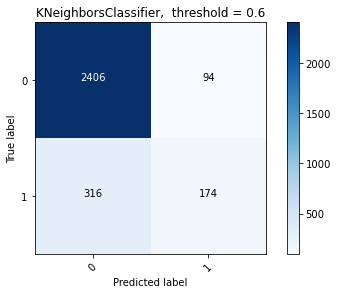

In [22]:
plot_confusion_matrix(confusion_matrix(val_labels, predicted_KN_6), classes=['0','1'],
                     title= 'KNeighborsClassifier,  threshold = 0.6')

In [23]:
threshold = 0.7

predicted_proba = model_KN.predict_proba(val_data)
predicted_KN_7 = (predicted_proba[:,1] >= threshold).astype('int')

print(classification_report(val_labels, predicted_KN_7))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2500
           1       0.69      0.28      0.40       490

    accuracy                           0.86      2990
   macro avg       0.78      0.63      0.66      2990
weighted avg       0.84      0.86      0.84      2990



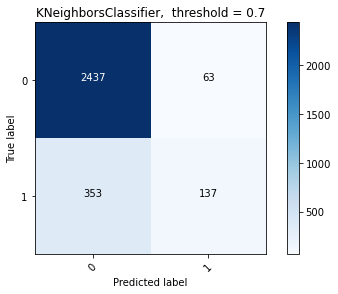

In [24]:
plot_confusion_matrix(confusion_matrix(val_labels, predicted_KN_7), classes=['0','1'],
                     title= 'KNeighborsClassifier,  threshold = 0.7')

In [25]:
threshold = 0.8

predicted_proba = model_KN.predict_proba(val_data)
predicted_KN_8 = (predicted_proba[:,1] >= threshold).astype('int')

print(classification_report(val_labels, predicted_KN_8))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      2500
           1       0.73      0.22      0.34       490

    accuracy                           0.86      2990
   macro avg       0.80      0.60      0.63      2990
weighted avg       0.84      0.86      0.83      2990



In [26]:
threshold = 0.9

predicted_proba = model_KN.predict_proba(val_data)
predicted_KN_9 = (predicted_proba[:,1] >= threshold).astype('int')

print(classification_report(val_labels, predicted_KN_9))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      2500
           1       0.82      0.16      0.27       490

    accuracy                           0.86      2990
   macro avg       0.84      0.58      0.60      2990
weighted avg       0.85      0.86      0.81      2990



## Метод опорных векторов

In [28]:
model = SVC(class_weight='balanced')
SVC_scoring = cross_validate(model, train_data, train_labels, scoring = ['accuracy', 'precision', 'recall'], cv = 5)
print('SVC_test_accuracy: ', SVC_scoring['test_accuracy'].mean())
print('SVC_test_precision: ', SVC_scoring['test_precision'].mean())
print('SVC_test_recall: ', SVC_scoring['test_recall'].mean())

SVC_test_accuracy:  0.7892763759230161
SVC_test_precision:  0.4195615809380816
SVC_test_recall:  0.7430131004366812


In [29]:
model_SVC = SVC(class_weight='balanced')
model_SVC.fit(train_data, train_labels)
predicted_SVC = model_SVC.predict(val_data)
print(classification_report(val_labels, predicted_SVC))

              precision    recall  f1-score   support

           0       0.93      0.79      0.86      2500
           1       0.40      0.72      0.52       490

    accuracy                           0.78      2990
   macro avg       0.67      0.75      0.69      2990
weighted avg       0.85      0.78      0.80      2990



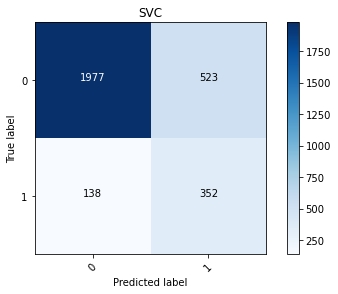

In [30]:
plot_confusion_matrix(confusion_matrix(val_labels, predicted_SVC), classes=['0','1'], title= 'SVC')

## Деревья решений

In [31]:
model = DecisionTreeClassifier(class_weight='balanced')
DT_scoring = cross_validate(model, train_data, train_labels, scoring = ['accuracy', 'precision', 'recall'], cv = 5)

print('DT_test_accuracy: ', DT_scoring['test_accuracy'].mean())
print('DT_test_precision: ', DT_scoring['test_precision'].mean())
print('DT_test_recall: ', DT_scoring['test_recall'].mean())

DT_test_accuracy:  0.8089160016842797
DT_test_precision:  0.41651105737526495
DT_test_recall:  0.41170612119819194


In [32]:
model_DT = DecisionTreeClassifier(class_weight='balanced')
model_DT.fit(train_data, train_labels)
predicted_DT = model_DT.predict(val_data)
print(classification_report(val_labels, predicted_DT))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2500
           1       0.41      0.41      0.41       490

    accuracy                           0.81      2990
   macro avg       0.65      0.65      0.65      2990
weighted avg       0.81      0.81      0.81      2990



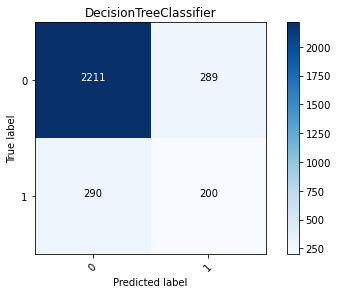

In [33]:
plot_confusion_matrix(confusion_matrix(val_labels, predicted_DT), classes=['0','1'],
                     title = 'DecisionTreeClassifier')

## Случайный лес

In [34]:
model = RandomForestClassifier(class_weight='balanced', max_features='log2')
RL_scoring = cross_validate(model, train_data, train_labels, scoring = ['accuracy', 'precision','recall'], cv = 5)
print('RL_test_accuracy: ', RL_scoring['test_accuracy'].mean())
print('RL_test_precision: ', RL_scoring['test_precision'].mean())
print('RL_test_recall: ', RL_scoring['test_recall'].mean())

RL_test_accuracy:  0.8669713775148657
RL_test_precision:  0.7161886792452831
RL_test_recall:  0.3129433846625297


In [35]:
model = RandomForestClassifier(max_features='log2')
RL_2_scoring = cross_validate(model, train_data, train_labels, scoring = ['accuracy', 'precision','recall'], cv = 5)
print('RL_2_test_accuracy: ', RL_2_scoring['test_accuracy'].mean())
print('RL_2_test_precision: ', RL_2_scoring['test_precision'].mean())
print('RL_2_test_recall: ', RL_2_scoring['test_recall'].mean())

RL_2_test_accuracy:  0.8663974900124266
RL_2_test_precision:  0.7065211878330689
RL_2_test_recall:  0.3146824484792768


In [36]:
model_RF = RandomForestClassifier(class_weight='balanced', max_features='log2')
# model_RF = RandomForestClassifier(class_weight='balanced')
model_RF.fit(train_data, train_labels)
predicted_RF = model_RF.predict(val_data)
# predicted_proba_RF = model_RF.predict_proba(val_data)
print(classification_report(val_labels, predicted_RF))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2500
           1       0.69      0.30      0.41       490

    accuracy                           0.86      2990
   macro avg       0.78      0.63      0.67      2990
weighted avg       0.85      0.86      0.84      2990



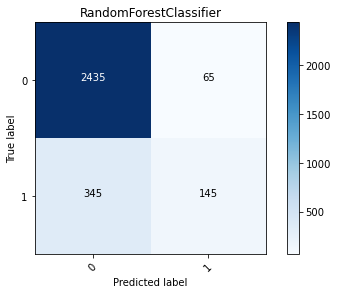

In [37]:
plot_confusion_matrix(confusion_matrix(val_labels, predicted_RF), classes=['0','1'],
                     title = 'RandomForestClassifier')

In [38]:
threshold = 0.6

predicted_proba = model_RF.predict_proba(val_data)
predicted_RF_6 = (predicted_proba[:,1] >= threshold).astype('int')

print(classification_report(val_labels, predicted_RF_6))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      2500
           1       0.78      0.21      0.33       490

    accuracy                           0.86      2990
   macro avg       0.82      0.60      0.63      2990
weighted avg       0.85      0.86      0.83      2990



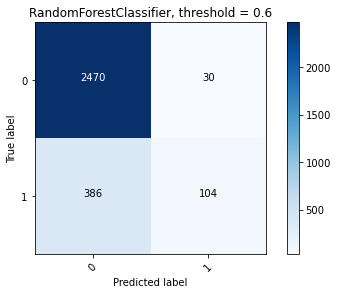

In [39]:
plot_confusion_matrix(confusion_matrix(val_labels, predicted_RF_6), classes=['0','1'],
                     title = 'RandomForestClassifier, threshold = 0.6')

In [40]:
threshold = 0.7

predicted_proba = model_RF.predict_proba(val_data)
predicted_RF_7 = (predicted_proba[:,1] >= threshold).astype('int')

print(classification_report(val_labels, predicted_RF_7))

              precision    recall  f1-score   support

           0       0.85      0.99      0.92      2500
           1       0.80      0.14      0.23       490

    accuracy                           0.85      2990
   macro avg       0.83      0.56      0.58      2990
weighted avg       0.85      0.85      0.81      2990



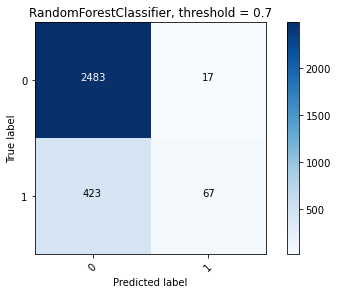

In [41]:
plot_confusion_matrix(confusion_matrix(val_labels, predicted_RF_7), classes=['0','1'],
                     title = 'RandomForestClassifier, threshold = 0.7')

In [42]:
threshold = 0.8

predicted_proba = model_RF.predict_proba(val_data)
predicted_RF_8 = (predicted_proba[:,1] >= threshold).astype('int')

print(classification_report(val_labels, predicted_RF_8))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2500
           1       0.82      0.08      0.14       490

    accuracy                           0.85      2990
   macro avg       0.83      0.54      0.53      2990
weighted avg       0.84      0.85      0.79      2990



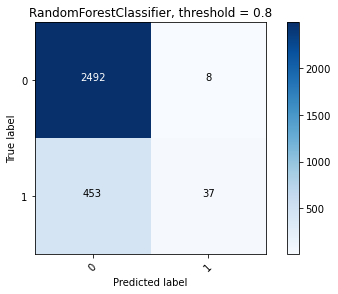

In [43]:
plot_confusion_matrix(confusion_matrix(val_labels, predicted_RF_8), classes=['0','1'],
                     title = 'RandomForestClassifier, threshold = 0.8')

In [44]:
threshold = 0.9

predicted_proba = model_RF.predict_proba(val_data)
predicted_RF_9 = (predicted_proba[:,1] >= threshold).astype('int')

print(classification_report(val_labels, predicted_RF_9))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      2500
           1       0.80      0.03      0.06       490

    accuracy                           0.84      2990
   macro avg       0.82      0.52      0.49      2990
weighted avg       0.83      0.84      0.77      2990



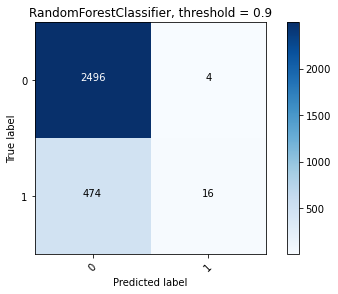

In [45]:
plot_confusion_matrix(confusion_matrix(val_labels, predicted_RF_9), classes=['0','1'],
                     title = 'RandomForestClassifier, threshold = 0.9')

## Бэггинг над деревьями

In [46]:
dt = DecisionTreeClassifier(class_weight='balanced')
model = BaggingClassifier(dt, n_estimators=70, n_jobs=-1)
Bagging_scoring = cross_validate(model, train_data, train_labels, scoring = ['accuracy', 'precision','recall'], cv = 5)
print('Bagging_test_accuracy: ', Bagging_scoring['test_accuracy'].mean())
print('Bagging_test_precision: ', Bagging_scoring['test_precision'].mean())
print('Bagging_test_recall: ', Bagging_scoring['test_recall'].mean())

Bagging_test_accuracy:  0.8586569923283113
Bagging_test_precision:  0.6317185068303447
Bagging_test_recall:  0.333053704129319


In [47]:
dt = DecisionTreeClassifier(class_weight='balanced')
model_Bag_70 = BaggingClassifier(dt, n_estimators=70, n_jobs=-1)
model_Bag_70.fit(train_data, train_labels)
predicted_Bag_70 = model_Bag_70.predict(val_data)
print(classification_report(val_labels, predicted_Bag_70))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2500
           1       0.65      0.32      0.43       490

    accuracy                           0.86      2990
   macro avg       0.77      0.65      0.68      2990
weighted avg       0.84      0.86      0.84      2990



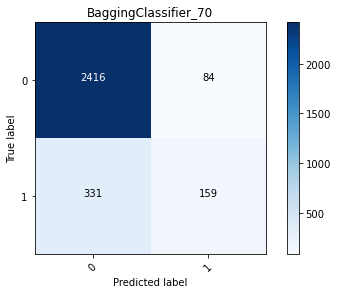

In [51]:
plot_confusion_matrix(confusion_matrix(val_labels, predicted_Bag_70), classes=['0','1'],
                     title = 'BaggingClassifier_70')

## Бустинги

In [53]:
model = XGBClassifier()
XGB_scoring = cross_validate(model, train_data, train_labels,scoring = ['accuracy', 'precision','recall'], cv = 5)
print('XGB_test_accuracy: ', XGB_scoring['test_accuracy'].mean())
print('XGB_test_precision: ', XGB_scoring['test_precision'].mean())
print('XGB_test_recall: ', XGB_scoring['test_recall'].mean())

C:\Users\evgen\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:24:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [54]:
model = XGBClassifier(scale_pos_weight=5)
XGB_2_scoring = cross_validate(model, train_data, train_labels,scoring = ['accuracy', 'precision','recall'], cv = 5)
print('XGB_2_test_accuracy: ', XGB_2_scoring['test_accuracy'].mean())
print('XGB_2_test_precision: ', XGB_2_scoring['test_precision'].mean())
print('XGB_2_test_recall: ', XGB_2_scoring['test_recall'].mean())

C:\Users\evgen\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:25:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:25:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:25:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:25:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [55]:
model_XGB = XGBClassifier()
model_XGB.fit(train_data, train_labels)
predicted_XGB  = model_XGB.predict(val_data)
print(classification_report(val_labels, predicted_XGB))

[19:25:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      2500
           1       0.56      0.33      0.42       490

    accuracy                           0.85      2990
   macro avg       0.72      0.64      0.66      2990
weighted avg       0.83      0.85      0.83      2990



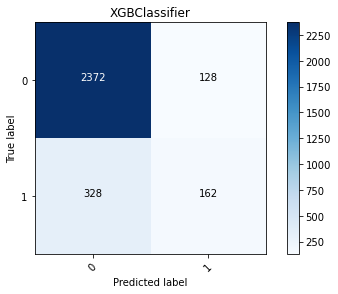

In [56]:
plot_confusion_matrix(confusion_matrix(val_labels, predicted_XGB), classes=['0','1'],
                     title = 'XGBClassifier')

In [57]:
model = LGBMClassifier()
LGBM_scoring = cross_validate(model, train_data, train_labels, scoring = ['accuracy', 'precision', 'recall'], cv = 5)
print('LGBM_test_accuracy: ', LGBM_scoring['test_accuracy'].mean())
print('LGBM_test_precision: ', LGBM_scoring['test_precision'].mean())
print('LGBM_test_recall: ', LGBM_scoring['test_recall'].mean())

LGBM_test_accuracy:  0.8567923714452969
LGBM_test_precision:  0.6111573113321428
LGBM_test_recall:  0.344369110549299


In [58]:
model = LGBMClassifier(scale_pos_weight=5)
LGBM_2_scoring = cross_validate(model, train_data, train_labels, scoring = ['accuracy', 'precision', 'recall'], cv = 5)
print('LGBM_2_test_accuracy: ', LGBM_2_scoring['test_accuracy'].mean())
print('LGBM_2_test_precision: ', LGBM_2_scoring['test_precision'].mean())
print('LGBM_2_test_recall: ', LGBM_2_scoring['test_recall'].mean())

LGBM_2_test_accuracy:  0.8123540889998049
LGBM_2_test_precision:  0.4525662805867324
LGBM_2_test_recall:  0.6853022293725581


In [59]:
model_LGBM = LGBMClassifier()
model_LGBM.fit(train_data, train_labels)
predicted_LGBM = model_LGBM.predict(val_data)
print(classification_report(val_labels, predicted_LGBM))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2500
           1       0.66      0.36      0.47       490

    accuracy                           0.87      2990
   macro avg       0.77      0.66      0.70      2990
weighted avg       0.85      0.87      0.85      2990



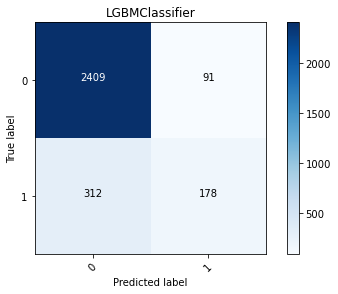

In [60]:
plot_confusion_matrix(confusion_matrix(val_labels, predicted_LGBM), classes=['0','1'],
                     title = 'LGBMClassifier')

In [61]:
model = CatBoostClassifier(silent=True)
Cat_scoring = cross_validate(model, train_data, train_labels, scoring = ['accuracy', 'precision','recall'], cv = 5)
print('Cat_test_accuracy: ', Cat_scoring['test_accuracy'].mean())
print('Cat_test_precision: ', Cat_scoring['test_precision'].mean())
print('Cat_test_recall: ', Cat_scoring['test_recall'].mean())

Cat_test_accuracy:  0.8626706103459962
Cat_test_precision:  0.6557768746989102
Cat_test_recall:  0.33999463724814216


In [62]:
model = CatBoostClassifier(scale_pos_weight=5, silent=True)
Cat_2_scoring = cross_validate(model, train_data, train_labels, scoring = ['accuracy', 'precision','recall'], cv = 5)
print('Cat_2_test_accuracy: ', Cat_2_scoring['test_accuracy'].mean())
print('Cat_2_test_precision: ', Cat_2_scoring['test_precision'].mean())
print('Cat_2_test_recall: ', Cat_2_scoring['test_recall'].mean())

Cat_2_test_accuracy:  0.8176604943977159
Cat_2_test_precision:  0.46306562142422775
Cat_2_test_recall:  0.693193135677622


In [63]:
model_Cat = CatBoostClassifier(silent=True)
model_Cat.fit(train_data, train_labels)
predicted_Cat = model_Cat.predict(val_data)
print(classification_report(val_labels, predicted_Cat))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2500
           1       0.66      0.35      0.46       490

    accuracy                           0.86      2990
   macro avg       0.77      0.66      0.69      2990
weighted avg       0.85      0.86      0.85      2990



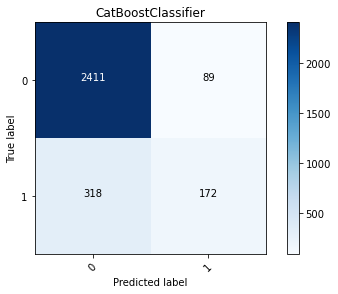

In [64]:
plot_confusion_matrix(confusion_matrix(val_labels, predicted_Cat), classes=['0','1'],
                     title = 'CatBoostClassifier')

### Сравнение случайного леса и ансамбля

In [67]:
# СЛУЧАЙНЫЙ ЛЕС

precision = []
recall = []
# threshold = 0.6
threshold = 0.7

for i in range(10):
    train_data, val_data, train_labels, val_labels = train_test_split(X, y, stratify=y, test_size=0.3)
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train_data)
    val_data = scaler.transform(val_data)
    model_RF = RandomForestClassifier(class_weight='balanced', max_features='log2')
    model_RF.fit(train_data, train_labels)
    predicted_proba = model_RF.predict_proba(val_data)
    predicted = (predicted_proba[:,1] >= threshold).astype('int')
    score = [metrics.precision_score(val_labels, predicted), metrics.recall_score(val_labels, predicted)]
    precision.append(score[0])
    recall.append(score[1])

In [68]:
import numpy as np
precision = np.array(precision)
print('precision: ', precision.mean())
recall = np.array(recall)
print('recall: ', recall.mean())

# threshold = 0.6
# precision:  0.7764920852684627
# recall:  0.21571428571428575

# threshold = 0.7
# precision:  0.7669463529219146
# recall:  0.1346938775510204

precision:  0.7669463529219146
recall:  0.1346938775510204


In [73]:
# Для ансамбля отбираем алгоритмы, которые показывали точность на 1-м классе выше 0.5

estimators = []

model1 = KNeighborsClassifier(weights='distance')
estimators.append(('KNeighbors', model1))
model2 = RandomForestClassifier(class_weight='balanced', max_features='log2')
estimators.append(('RandomForest', model2))
dt = DecisionTreeClassifier(class_weight='balanced')
model3 = BaggingClassifier(dt, n_estimators=70)
estimators.append(('Bagging', model3))
model4 = XGBClassifier()
estimators.append(('XGB', model4))
model5 = LGBMClassifier()
estimators.append(('LGBM', model5))
model6 = CatBoostClassifier(silent=True)
estimators.append(('Cat', model6))

ensemble = VotingClassifier(estimators, voting='soft')

In [74]:
precision_V = []
recall_V = []
# threshold = 0.6
threshold = 0.7

for i in range(10):
    train_data, val_data, train_labels, val_labels = train_test_split(X, y, stratify=y, test_size=0.3)
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train_data)
    val_data = scaler.transform(val_data)
    ensemble.fit(train_data, train_labels)
    predicted_proba = ensemble.predict_proba(val_data)
    predicted = (predicted_proba[:,1] >= threshold).astype('int')
    score = [metrics.precision_score(val_labels, predicted), metrics.recall_score(val_labels, predicted)]
    precision_V.append(score[0])
    recall_V.append(score[1])

C:\Users\evgen\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\evgen\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\evgen\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\evgen\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\evgen\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\evgen\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:56:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\evgen\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\evgen\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\evgen\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\evgen\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [75]:
precision_V = np.array(precision_V)
recall_V = np.array(recall_V)
print('precision_V: ', precision_V.mean())
print('recall_V: ', recall_V.mean())

# threshold = 0.6
# precision_V:  0.7339554650490128
# recall_V:  0.2528571428571429

# threshold = 0.7
# precision_V:  0.7815879681451394
# recall_V:  0.1563265306122449

precision_V:  0.7815879681451394
recall_V:  0.1563265306122449


In [76]:
estimators = []

model1 = KNeighborsClassifier(weights='distance')
estimators.append(('KNeighbors', model1))
model2 = RandomForestClassifier(class_weight='balanced', max_features='log2')
estimators.append(('RandomForest', model2))
dt = DecisionTreeClassifier(class_weight='balanced')
model3 = BaggingClassifier(dt, n_estimators=70)
estimators.append(('Bagging', model3))
model4 = XGBClassifier()
estimators.append(('XGB', model4))
model5 = LGBMClassifier()
estimators.append(('LGBM', model5))
model6 = CatBoostClassifier(silent=True)
estimators.append(('Cat', model6))

ensemble = VotingClassifier(estimators, voting='hard')

In [77]:
precision_V = []
recall_V = []

for i in range(10):
    train_data, val_data, train_labels, val_labels = train_test_split(X, y, stratify=y, test_size=0.3)
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train_data)
    val_data = scaler.transform(val_data)
    ensemble.fit(train_data, train_labels)
    predicted = ensemble.predict(val_data)
    score = [metrics.precision_score(val_labels, predicted), metrics.recall_score(val_labels, predicted)]
    precision_V.append(score[0])
    recall_V.append(score[1])

C:\Users\evgen\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:01:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\evgen\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:02:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\evgen\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:02:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\evgen\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:02:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\evgen\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:02:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\evgen\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:02:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\evgen\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:02:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\evgen\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:03:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\evgen\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:03:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\evgen\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:03:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [78]:
precision_V = np.array(precision_V)
recall_V = np.array(recall_V)
print('precision_V: ', precision_V.mean())
print('recall_V: ', recall_V.mean())

# без threshold
# precision_V:  0.7132133002274316
# recall_V:  0.3136734693877551

precision_V:  0.7132133002274316
recall_V:  0.3136734693877551


In [82]:
# Для ансамбля отбираем алгоритмы, которые показывали точность на 1-м классе выше 0.6

estimators = []

# model1 = KNeighborsClassifier(weights='distance')
# estimators.append(('KNeighbors', model1))
model2 = RandomForestClassifier(class_weight='balanced', max_features='log2')
estimators.append(('RandomForest', model2))
dt = DecisionTreeClassifier(class_weight='balanced')
model3 = BaggingClassifier(dt, n_estimators=70)
estimators.append(('Bagging', model3))
# model4 = XGBClassifier()
# estimators.append(('XGB', model4))
# model5 = LGBMClassifier()
# estimators.append(('LGBM', model5))
model6 = CatBoostClassifier(silent=True)
estimators.append(('Cat', model6))

ensemble = VotingClassifier(estimators, voting='soft')

In [83]:
precision_V = []
recall_V = []
# threshold = 0.6
threshold = 0.7

for i in range(10):
    train_data, val_data, train_labels, val_labels = train_test_split(X, y, stratify=y, test_size=0.3)
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train_data)
    val_data = scaler.transform(val_data)
    ensemble.fit(train_data, train_labels)
    predicted_proba = ensemble.predict_proba(val_data)
    predicted = (predicted_proba[:,1] >= threshold).astype('int')
    score = [metrics.precision_score(val_labels, predicted), metrics.recall_score(val_labels, predicted)]
    precision_V.append(score[0])
    recall_V.append(score[1])

In [84]:
precision_V = np.array(precision_V)
recall_V = np.array(recall_V)
print('precision_V: ', precision_V.mean())
print('recall_V: ', recall_V.mean())

# threshold = 0.6
# precision_V:  0.7580366810542423
# recall_V:  0.22102040816326526

# threshold = 0.7
# precision_V:  0.7920597753934884
# recall_V:  0.13204081632653059

precision_V:  0.7920597753934884
recall_V:  0.13204081632653059


Точность для 1-го класса в 0.79 при полноте в 0.13 дает threshold = 0.7 и сочетание в ансамбле следующих алгоритмов: случайного леса, бэггинга и алгоритма CatBoost. Обучим этот ансамбль на всех данных для дальнейшей работы с новыми данными.

In [85]:
estimators = []

model2 = RandomForestClassifier(class_weight='balanced', max_features='log2')
estimators.append(('RandomForest', model2))
dt = DecisionTreeClassifier(class_weight='balanced')
model3 = BaggingClassifier(dt, n_estimators=70)
estimators.append(('Bagging', model3))
model6 = CatBoostClassifier(silent=True)
estimators.append(('Cat', model6))

ensemble = VotingClassifier(estimators, voting='soft')

In [86]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
ensemble.fit(X, y)

VotingClassifier(estimators=[('RandomForest',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_features='log2')),
                             ('Bagging',
                              BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced'),
                                                n_estimators=70)),
                             ('Cat',
                              <catboost.core.CatBoostClassifier object at 0x0000017D6ED65520>)],
                 voting='soft')

In [87]:
import pickle
pickle.dump(ensemble, open('Coursework_ensemble', 'wb'))